In [1]:
# %%sh
# sudo apt install fonts-cmu texlive-latex-extra cm-super dvipng

Imports and package configurations

In [2]:
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import seaborn as sns
import sys
from typing import *
import wandb
import wandb.apis

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{bm} \usepackage{amsmath}'

if not os.path.exists("./out"):
    os.makedirs("./out")

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


Functionality for loading and processing result data

In [3]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary and run.notes != "buggy" and run.id != "dt7fl1ho":
        task = run.config["task"]["name"]
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match",
            triviaqa="match",
            cnn_dailymail="rougeL",
            wikitext_bpc="bpc",
            repetition="match_length_char",
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        sparsity["method"] = sparsity.pop("score", None)
        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            id=run.id,
            task=task,
            model=run.config["model"].split("/")[1].replace("-hf", "").lower(),
            n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
        )


def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))


def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "local":
        # write 1*(k, v) + read sparse_k*v
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] in ["ann", "low_rank", "sparq", "sparse_q"]:
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    elif s["name"] == "oracle":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write mean_v
        index_elements = 2 * s["head_size"]
    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_heads"]


def memory_transfers(d):
    return d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1))
    

def add_dense_as_sparse(df: pd.DataFrame, attribute: str = "name") -> pd.DataFrame:
    """Add 'dense' as if it were a sparse technique.
    Note that this only gives it the sparse 'name' string (not k, etc).
    """
    def _map(g: pd.DataFrame) -> pd.DataFrame:
        g_dense = g[g["name"]=="dense"]
        if len(g_dense) != 1:
            print(f"Warning: multiple dense results found for {g.task.iloc[0]}, {g.model.iloc[0]}", file=sys.stderr)
        return (g.groupby("name")
                # .apply(lambda gg: gg if gg.name=="dense" else pd.concat([gg, g_dense.assign(**{attribute: gg[attribute]})]))
                .apply(lambda gg: gg if gg.name=="dense" else pd.concat([gg, g_dense.assign(name=gg.name)]))
                .reset_index(drop=True))
    return df.groupby(["task", "model"]).apply(_map).reset_index(drop=True)

Load the Weights and Biases API to retrieve the latest results

In [4]:
api = wandb.Api()

## Ablation I: Key Cache Compression
#### This ablation compares SparQ Attention against a hypothetical Orcale (which is modelled as being able to identify the exact top-k key indices without any data transfer)

Load the relevant sweeps and experiments

In [5]:
oracle_df = (load_sweep("RMOE-71-ablations-oracle-nearest-neighbors")
    .pipe(lambda d: d.assign(name="oracle"))
)

low_rank_df = (load_sweep("RMOE-71-ablations-low-ranks-v5-no-reallocation")
    .pipe(lambda d: d.assign(name="low_rank"))
    .pipe(lambda d: d.loc[d["rank"] == 16])
)

sparq_df = (
    pd.concat([
        load_sweep("RMOE-68-workshop-sweep"),
        load_sweep("RMOE-68-lower-r"),
    ])
    .pipe(lambda d: d.loc[d["method"] == "sparse_q"])
    .pipe(lambda d: d.loc[d["task"] == "squad"])
    .pipe(lambda d: d.loc[d["model"] == "llama-2-7b"])
    .pipe(lambda d: d.loc[d["k"] == 128])
    .pipe(lambda d: d.assign(name="sparq"))
)

dense_df = (load_sweep("RMOE-68-workshop-sweep")
    .pipe(lambda d: d.loc[d["name"] == "dense"])
    .pipe(lambda d: d.loc[d["task"] == "squad"])
    .pipe(lambda d: d.loc[d["model"] == "llama-2-7b"])    
)

df = pd.concat([oracle_df, low_rank_df, sparq_df, dense_df])
df = add_dense_as_sparse(df.pipe(memory_transfers))

Define the plotting functionality for the first ablation

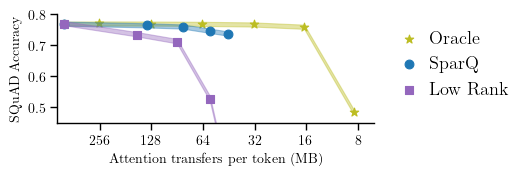

In [6]:
TASK_LABELS = {
    "squad": "SQuAD Accuracy", 
    "cnn_dailymail": "CNN/DailyMail ROUGE-L",
    "triviaqa": "TriviaQA Accuracy",
    "wikitext_bpc": "WikiText-$103$ BPC",
    "repetition": "Repetition\nmatch length",
}

STYLES = {
    "oracle": {
        "color": sns.color_palette()[8],
        "marker": "*",
        "label": "Oracle",
    },
    "sparq": {
        "color": sns.color_palette()[0],
        "marker": "o",
        "label": "SparQ",
    },
    "low_rank": {
        "color": sns.color_palette()[4],
        "marker": "s",
        "label": "Low Rank",
    },
}


def plot_ablation_1(model: str, task: str, ax: matplotlib.axes.Axes) -> None:
    dense = df[df.name == "dense"].iloc[0]
    
    for name, style in STYLES.items():
        data = df[df.name == name].sort_values("transfers")
        lower = data.score - data.score_stderr
        upper = data.score + data.score_stderr
        fill_style = {"color": style["color"], "alpha": 0.4}
        ax.fill_between(data.transfers, lower, upper, **fill_style)
        ax.scatter(data.transfers, data.score, s=40, **style)
        
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f}")
    ax.set_xlim((dense.transfers * 1.1, dense.transfers / 64))
    ax.set_xlabel("Attention transfers per token (MB)", fontsize=10)
    ax.set_ylabel(TASK_LABELS[task], fontsize=10)
    ax.legend(frameon=False, ncols=1, handletextpad=0.1, bbox_to_anchor=(1, 1))
    ax.set_ylim((0.45, 0.8))
    ax.set_yticks([0.5, 0.6, 0.7, 0.8])
    ax.tick_params(axis='both', which='major', labelsize=10)


plt.figure(figsize=(5.5, 2))
ax = plt.gca()
plot_ablation_1("llama-2-7b", "squad", ax=ax)
sns.despine()
plt.tight_layout()
plt.savefig(f"out/key_cache_compression.pdf", bbox_inches="tight")

## Ablation II: Approximate Softmax Temperature Investigation
#### This ablation investigates different softmax temperatures used in Step 1 of SparQ Attention, which influences the mass reallocated to the mean value vector.

Load and format the relevant sweep

In [7]:
df = load_sweep("RMOE-71-ablations-sparq-scale-sweep-v2")
df = df[df.model == "llama-2-7b"]
df["scale_type"].fillna("lim_0", inplace=True)

Define the plotting functionality for the second ablation

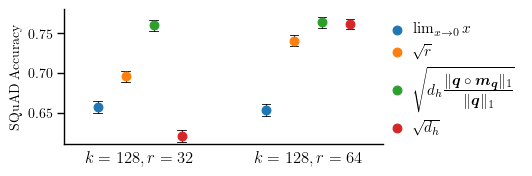

In [8]:
SETUP_WIDTH = 0.5
SETUP_SPACING = 0.5
STDERR_WIDTH = 0.025
OVERHANG = 0.2

STYLES = {
    "lim_0": {
        "color": sns.color_palette()[0],
        "label": r"$\lim_{x \rightarrow 0} x$",
    },
    "rank": {
        "color": sns.color_palette()[1],
        "label": r"$\sqrt{r}$", 
    },
    "l1": {
        "color": sns.color_palette()[2],
        "label": r"$\sqrt{d_h\displaystyle\frac{\lVert\bm{q}\circ\bm{m_q}\rVert_1}{\lVert\bm{q}\rVert_1}}$",
    },
    "head_size": {
        "color": sns.color_palette()[3],
        "label": r"$\sqrt{d_h}$", 
    },
}


def plot_ablation_2(configs: List[Dict], ax: matplotlib.axes.Axes) -> None:
    x_locs, x_labels = [], []
    
    for config_index, config in enumerate(configs):
        k, rank = config["k"], config["rank"]
        
        x_start = config_index * (SETUP_WIDTH + SETUP_SPACING)
        x_end = x_start + SETUP_WIDTH
        xs = np.linspace(x_start, x_end, 4)        
        x_locs += [x_start + SETUP_WIDTH / 2]
        x_labels += [r"\large" + f"$k={k}, r={rank}$"] 
        
        data = df[(df["k"] == k) & (df["rank"] == rank)]
  
        for x, (scale_type, style) in zip(xs, STYLES.items()):
            result = data[data["scale_type"] == scale_type]
            result = result.to_dict("records")[0]

            lower = result["score"] - result["score_stderr"]
            upper = result["score"] + result["score_stderr"]
            ax.plot([x, x], [lower, upper], color="k", linewidth=0.6)
            for bound in [lower, upper]:
                bound_x = [x - STDERR_WIDTH, x + STDERR_WIDTH]
                bound_y = [bound, bound]
                ax.plot(bound_x, bound_y, color="k", linewidth=0.6)
            if config_index:
                style.pop("label")
            ax.scatter(x, result["score"], **style, zorder=2, s=40)
                       
    ax.set_xticks(x_locs, x_labels, fontsize=10)
    ax.tick_params(axis=u'x', which=u'both',length=0, pad=5)
    ax.tick_params(axis=u'y', which=u'major', labelsize=10)
    ax.legend(frameon=False, bbox_to_anchor=(0.95, 1), handletextpad=0.1, fontsize=11)
    ax.set_ylim([0.61, 0.78])
    ax.set_ylabel("SQuAD Accuracy", fontsize=10)
    ax.set_xlim([-OVERHANG, x + OVERHANG])

plt.figure(figsize=(5.5, 2))
ax = plt.gca()
plot_ablation_2([{"k": 128, "rank": 32}, {"k": 128, "rank": 64}], ax=ax)
sns.despine()
plt.tight_layout()
plt.savefig(f"out/softmax_temperature.pdf", bbox_inches="tight")

## Ablation III: Recipe
#### This ablation investigates different configurations of k and rank to determine what the best rule of thumb is to attain a good tradeoff between performance and data-transfer.

Load relevant results and format them into a Pandas DataFrame

In [9]:
SWEEPS = ["RMOE-68-workshop-sweep", "RMOE-71-ablations-recipe-k=32-and-256"]
MODELS = ["llama-2-7b"]
TASKS = ["repetition", "squad"]

df = pd.concat([
    load_sweep(sweep)
        .pipe(lambda d: d[d["name"].isin(["ann", "dense"])])
        .pipe(lambda d: d[d["model"].isin(MODELS)])
        .pipe(lambda d: d[d["task"].isin(TASKS)])
        .pipe(memory_transfers)
    for sweep in SWEEPS
])

Define the plotting functionality for the third ablation

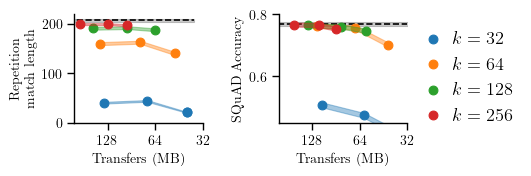

In [10]:

def plot_ablation_3(model: str, task: str, ax: matplotlib.axes.Axes) -> None:
    data = add_dense_as_sparse(df[(df.model == model) & (df.task == task)])
    
    dense = data[data.name == "dense"].iloc[0]
    lower = dense.score - dense.score_stderr
    upper = dense.score + dense.score_stderr
    dense_fill_x = [dense.transfers * 1.1, dense.transfers / 14]
    dense_fill_y = [[lower, lower], [upper, upper]]
    dense_fill_kwargs = {"color": "k", "alpha": 0.2, "zorder": -2}
    dense_plot_kwargs = {"color": "k", "linestyles": "--", "zorder": -1}
    ax.fill_between(dense_fill_x, *dense_fill_y, **dense_fill_kwargs)
    ax.hlines(dense.score, *dense_fill_x, **dense_plot_kwargs)

    ks = map(int, sorted(set(data[data["rank"] > 0]["k"])))
    for k, color in zip(ks, sns.color_palette()):
        k_data = data[data["k"] == k].sort_values("transfers")
        lower = k_data.score - k_data.score_stderr
        upper = k_data.score + k_data.score_stderr
        ann_fill_kwargs = {"color": color, "alpha": 0.4}
        ann_plot_kwargs = {"color": color, "s": 40, "label": f"$k={k}$"}
        ax.fill_between(k_data.transfers, lower, upper, **ann_fill_kwargs)
        ax.scatter(k_data.transfers, k_data.score, **ann_plot_kwargs)

    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f}")
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xlim([2 ** 27.7, 2 ** 25])
    ax.set_ylim({"squad": [0.45, 0.8], "repetition": [0, 220]}[task])
    ax.set_xlabel("Transfers (MB)", fontsize=10)
    ax.set_ylabel(TASK_LABELS[task], fontsize=10)
    ax.tick_params(axis='y', which='major', labelsize=10)


fig, axs = plt.subplots(len(MODELS), len(TASKS), figsize=(5.5, 2), squeeze=False)
for axr, model in zip(axs, MODELS):
    for ax, task in zip(axr, TASKS):
        plot_ablation_3(model, task, ax)

_ = ax.legend(frameon=False, ncols=1, handletextpad=0.1, bbox_to_anchor=(0.93, 1))
sns.despine()
plt.tight_layout()